Normalizar <br>
Rodar 21 vezes <br>
Combinar os paretos (concatenar) <br>
Rodar dominância nos combinados  <br>
Ponto de nadir dos combinados -> ponto de referência para o hipervolume <br>


In [27]:
from pymoo.factory import get_problem, get_reference_directions
from pymoo.util.plotting import plot
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.optimize import minimize
from pymoo.factory import get_performance_indicator
import numpy as np

import json


def compare_algorithms(n_iter, n_gen, n_obj, k=5, save_json=False):
    """[Runs MOEAD, NSGA2 and NSGA3 on a benchmark problem and outputs everything to a dict. Saving to json is optional.]

    Args:
        n_iter ([int]): [Number of iterations to run]
        n_gen ([int]): Number of generations to evaluate
        n_obj ([int]): Number of objectives for the problem
        k (int, optional): k constant for dtlz1 problem
        save_json (bool, optional): Whether the function is supposed to save to a file or not

    Returns:
        [dict]: [Dict containing performance indicators and solutions provided]
    """    
    ref_dirs = get_reference_directions("das-dennis", n_obj, n_partitions=6)

    ref_point = np.ones(n_obj)

    pop_size = ref_dirs.shape[0] # population size as a minimum to match ref dirs

    n_var = k + n_obj - 1

    problem = get_problem("dtlz1", n_obj=n_obj, n_var=n_var)

    alg1 = NSGA2(pop_size=pop_size)
    alg2 = NSGA3(ref_dirs=ref_dirs)
    alg3 = MOEAD(ref_dirs,
                n_neighbors=3,
                prob_neighbor_mating=0.7)

    hypervolume1 = []
    hypervolume2 = []
    hypervolume3 = []

    sols1 = []
    sols2 = []
    sols3 = []

    for i in range(n_iter):
        seed = np.random.randint(0, 100)

        sol1 = minimize(problem,
                        alg1,
                        ('n_gen', n_gen),
                        seed=seed,
                        verbose=False)

        sol2 = minimize(problem,
                        alg2,
                        ('n_gen', n_gen),
                        seed=seed,
                        verbose=False)
        sol3 = minimize(problem,
                        alg3,
                        ('n_gen', n_gen),
                        seed=seed,
                        verbose=False)

        # normalize
        for obj_idx in range(problem.n_obj):
            max_value1 = max(sol1.F[:, obj_idx])
            sol1.F[:, obj_idx] = sol1.F[:, obj_idx] / max_value1

            max_value2 = max(sol2.F[:, obj_idx])
            sol2.F[:, obj_idx] = sol2.F[:, obj_idx] / max_value2

            max_value3 = max(sol3.F[:, obj_idx])
            sol3.F[:, obj_idx] = sol3.F[:, obj_idx] / max_value3


        hypervolume1_temp = get_performance_indicator("hv", ref_point = ref_point)
        hypervolume1.append(hypervolume1_temp.do(sol1.F))
        sols1.append(sol1.F.tolist())
            
        hypervolume2_temp = get_performance_indicator("hv", ref_point = ref_point)
        hypervolume2.append(hypervolume2_temp.do(sol2.F))
        sols2.append(sol2.F.tolist())

        hypervolume3_temp = get_performance_indicator("hv", ref_point = ref_point)
        hypervolume3.append(hypervolume3_temp.do(sol3.F))
        sols3.append(sol3.F.tolist())

        print('Iteration ' + str(i) + ' executed.')

    output = {
        'sols1' : sols1,
        'sols2' : sols2,
        'sols3' : sols3,
        'hypervolume1' : hypervolume1,
        'hypervolume2' : hypervolume2,
        'hypervolume3' : hypervolume3
        }

    # save to a file
    if save_json:
        json_string = json.dumps(output)
        with open('output_dtlz1_'+str(n_iter)+'_iterations_'+str(n_obj)+'_objs.json','w') as outfile:
            outfile.write(json_string)

    return output

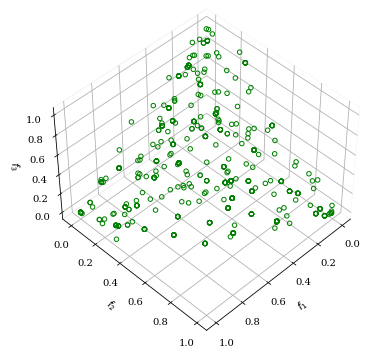

In [99]:
import numpy as np
import json
from pymoo.visualization.scatter import Scatter

n_obj = 3

# read files
with open('output_dtlz1_21_iterations_'+str(n_obj)+'_objs.json') as file:
    out = json.load(file)

# scatter accepts only numpy arrays
obj_nsgaii = np.array([np.array(xi) for xi in out['sols1']])
obj_nsgaiii = np.array([np.array(xi) for xi in out['sols2']])
obj_moead = np.array([np.array(xi) for xi in out['sols3']])

plot = Scatter()
# add all solutions to a plot
for sol in range(len(obj_nsgaiii)):
    plot.add(obj_moead[sol], facecolor="none", edgecolor="green")
plot.show()



In [4]:
n_iter = 3
n_gen = 50
n_obj = 3
k = 5
n_var = k + n_obj - 1
pop_size = 50

ref_dirs = get_reference_directions("das-dennis", n_obj, n_partitions=3)

problem = get_problem("dtlz1", n_obj=n_obj, n_var=n_var)

alg = MOEAD(ref_dirs,
                n_neighbors=2,
                prob_neighbor_mating=0.7)

hypervolume3 = []

for i in range(n_iter):
        sol = minimize(problem,
                        alg,
                        ('n_gen', n_gen),
                        seed=None,
                        verbose=False)

        # normalize
        for obj_idx in range(problem.n_obj):
               max_value = max(sol.F[:, obj_idx])
               sol.F[:, obj_idx] = sol.F[:, obj_idx] / max_value


        hypervolume3_temp = get_performance_indicator("hv", ref_point = np.ones(n_obj))
        hypervolume3.append(hypervolume3_temp.do(sol.F))

        print('Iteration ' + str(i) + ' executed.')

# por que dá negativo para 9 objetivos?
# por que o hiper volume dá igual para todas as vezes, até 8 objetivos? testei nsgaii e moead
hypervolume3

Iteration 0 executed.
Iteration 1 executed.
Iteration 2 executed.


[0.015931903877532475, 0.01390787060014548, 0.2066416053741834]

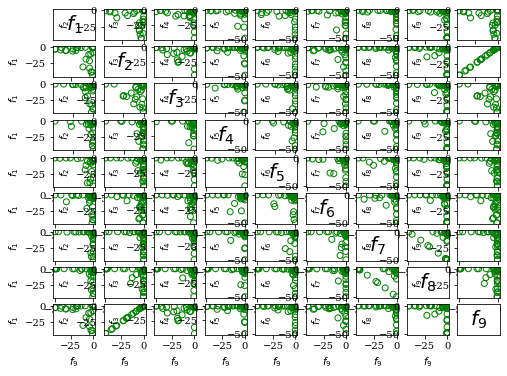

In [148]:

    plot = Scatter()
    # plot.add(problem.pareto_front(), plot_type="line", color="black")
    plot.add(sol.F, facecolor="none", edgecolor="green")
    plot.show()


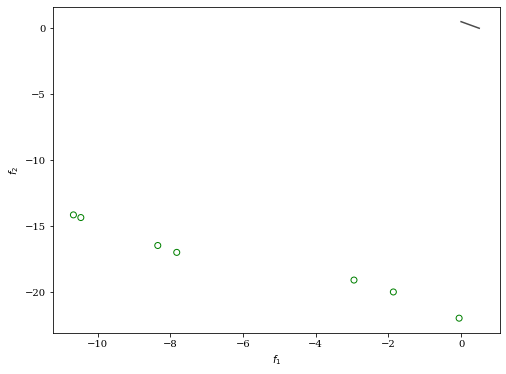

In [19]:
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
# plot.add(sol1.F, facecolor="none", edgecolor="red")
# plot.add(sol2.F, facecolor="none", edgecolor="blue")
plot.add(sols[2].F, facecolor="none", edgecolor="green")
plot.show()
